In [12]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

parent_folder = '/home/fadi/dev/ws_hk1d_ident/ident_data/rosbags/master_red_hk1d_rob/with_fric_compensation'
dataset_folder = 'rosbag2_2024_10_22-20_34_21'
path_to_bag = os.path.join(parent_folder, dataset_folder)

identification_info_topic_name = '/identification_controller_cl/identification_info'
simulation_time_topic_name = '/simulation_time'
topic_list = [identification_info_topic_name, simulation_time_topic_name]

import nml_bag
from tqdm import tqdm

reader = nml_bag.Reader(path_to_bag, topics=topic_list)
rosbag_data = reader.records


In [39]:
def get_simulation_time(rosbag_raw_data, time_topic_name=None):
    data_dict = {
        'ros_time': [],
        'time': []
    }
    for msg_data in rosbag_raw_data:
        if (msg_data['topic'] == time_topic_name):
            # Retrieve ros timestamp
            data_dict['ros_time'] += [msg_data['time_ns']]
            data_dict['time'] += [msg_data['data']]

    data_dict['ros_time'] = np.array(data_dict['ros_time'])
    data_dict['time'] = np.array(data_dict['time'])
    return data_dict



In [40]:

def get_identification_info(rosbag_raw_data, topic_name=None):
    data_dict = {
        'ros_time': [],
        'joint_effort': [],
        'joint_velocity': [],
        'joint_position': [],
        'joint_ref_position': [],
        'joint_ref_effort': [],
        'external_effort': [],
        'friction_compensation': []
    }
    for msg_data in rosbag_raw_data:
        if (msg_data['topic'] == topic_name):
            # Retrieve ros timestamp
            data_dict['ros_time'] += [msg_data['time_ns']]
            # Retrieve the robot state
            data_dict['joint_effort'] += [msg_data['measured_joint_effort']]
            data_dict['joint_velocity'] += [msg_data['measured_joint_velocity']]
            data_dict['joint_position'] += [msg_data['measured_joint_position']]
            data_dict['joint_ref_position'] += [msg_data['reference_joint_position']]
            data_dict['joint_ref_effort'] += [msg_data['reference_effort']]
            data_dict['external_effort'] += [msg_data['external_effort']]
            data_dict['friction_compensation'] += [msg_data['friction_compensation']]
    # Consolidate data as numpy arrays
    for key_, data_list_ in data_dict.items():
        data_dict[key_] = np.array(data_list_)
    return data_dict

In [41]:
local_data = {}
local_data['simulation_time'] = get_simulation_time(rosbag_data, simulation_time_topic_name)
local_data['identification_info'] = get_identification_info(rosbag_data, identification_info_topic_name)

In [45]:
# modifying time
simulation_t0 = 0 # plot from t0 for simulation_length_seconds 
simulation_length_seconds = 200 #np.max(local_data['simulation_time']['time'])

dataset = local_data
time_regression_res = scipy.stats.linregress(
    dataset['simulation_time']['ros_time'],
    dataset['simulation_time']['time'] - simulation_t0
)
assert(time_regression_res.rvalue > 0.99)

def unsafe_map_to_simulation_time(ros_time_in):
    return time_regression_res.intercept + time_regression_res.slope*ros_time_in

def map_to_simulation_time(ros_time_in):
    naive_value = unsafe_map_to_simulation_time(ros_time_in) 
    if ((naive_value < 0.0) or (naive_value > simulation_length_seconds)):
        return -1  # np.NaN
    else:
        return naive_value

def append_simulation_time(data_dict):
    data_dict['time'] = np.zeros(data_dict['ros_time'].shape)
    for idx in range(data_dict['time'].shape[0]):
        data_dict['time'][idx] = map_to_simulation_time(data_dict['ros_time'][idx])

# Cropping function
def crop_time_serie(data_dict, key, slicing = slice(None)):
    return data_dict[key][np.asarray(data_dict['time'] > -1).nonzero()][slicing]

append_simulation_time(local_data['identification_info'])


print('OK!\n')

OK!



Text(0.5, 1.0, 'Joint position')

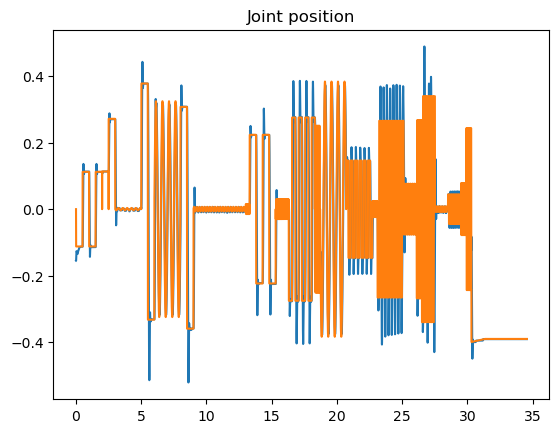

In [46]:
# Plotting with cropping time 
plt.figure()
plt.plot(crop_time_serie(local_data['identification_info'], 'time'), crop_time_serie(local_data['identification_info'], 'joint_position'))
plt.plot(crop_time_serie(local_data['identification_info'], 'time'), crop_time_serie(local_data['identification_info'], 'joint_ref_position'))
plt.title('Joint position')


In [47]:
# Exporting to .mat files
import scipy.io
mat_file_name = 'dataset.mat'
joint_position = crop_time_serie(local_data['identification_info'], 'joint_position')
joint_ref_position = crop_time_serie(local_data['identification_info'], 'joint_ref_position')
joint_velocity = crop_time_serie(local_data['identification_info'], 'joint_velocity')
joint_effort = crop_time_serie(local_data['identification_info'], 'joint_effort')
external_effort = crop_time_serie(local_data['identification_info'], 'external_effort')
friction_compensation = crop_time_serie(local_data['identification_info'], 'friction_compensation')
time = crop_time_serie(local_data['identification_info'], 'time')

scipy.io.savemat(mat_file_name, {
    'joint_position': joint_position,
    'joint_ref_position': joint_ref_position,
    'joint_velocity': joint_velocity,
    'joint_effort': joint_effort,
    'external_effort': external_effort,
    'friction_compensation': friction_compensation,
    'timestamps': time
})